# XGBoost

In [2]:
import os
import re

project_path = re.findall(
    pattern=r".+monday-vip-consulting",
    string=os.path.abspath(os.getcwd()),
)[0]
os.chdir(os.path.join(project_path))
%load_ext jupyter_black

In [21]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from skopt import BayesSearchCV
from src.utils.pather import Pather
from skopt.space import Integer

In [4]:
pather = Pather()
features = pd.read_csv(pather.features).set_index("account_id")
y = pd.read_csv(pather.target).set_index("account_id")["lead_score"].values

# X_encoded = features.values
use_categorical = False
categorical_cols = ["payment_currency", "industry", "country"]
features = features.astype(
    {
        "payment_currency": "category",
        "industry": "category",
        "country": "category",
    }
)
# if not use_categorical:
#     features = features.drop(categorical_cols, axis=1)
#     X_encoded = features.values
# else:
#     one_hot_encoder = OneHotEncoder(sparse=False, drop="first")
#     preprocessor = ColumnTransformer(
#         transformers=[("cat", one_hot_encoder, categorical_cols)],
#         remainder="passthrough",
#     )
#     X_encoded = preprocessor.fit_transform(features)

In [5]:
# X_encoded.shape

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42,
)

In [7]:
print(sum(y == 1) / len(y))
print(sum(y_train == 1) / len(y_train))
print(sum(y_test == 1) / len(y_test))

0.02557176275126842
0.025572150963124544
0.025570209912242115


In [40]:
model = xgb.XGBClassifier(
    learning_rate=0.05,
    n_estimators=20,
    max_depth=20,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    seed=42,
    enable_categorical=True,
    max_cat_to_onehot=5,
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=5, max_delta_step=None,
              max_depth=20, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [42]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_precision = f1_score(y_train, y_train_pred)
test_precision = f1_score(y_test, y_test_pred)

print(f"Train f1 score: {train_precision}")
print(f"Test f1 score: {test_precision}")
# print(f"Random Model: {sum(y == 1) / len(y)}")

Train f1 score: 0.022307424189613102
Test f1 score: 0.0028153153153153147


## Hyperparameter tuning

In [47]:
param_space = {
    "learning_rate": (0.1, 0.3, "log-uniform"),
    "n_estimators": Integer(20, 300),
    "max_depth": Integer(5, 100),
    "min_child_weight": Integer(1, 3),
    # "gamma": Real(0, 0.1, prior="log-uniform"),
    # "subsample": Real(0.7, 0.9, prior="uniform"),
    # "colsample_bytree": Real(0.7, 0.9, prior="uniform"),
}

In [48]:
xgb_classifier = xgb.XGBClassifier(
    gamma=0,  # Minimum loss reduction required to make a further partition
    subsample=0.8,  # Fraction of samples used for tree building
    colsample_bytree=0.8,  # Fraction of features used for tree building
    objective="binary:logistic",  # Binary classification
    seed=42,  # Random seed for reproducibility
    enable_categorical=True,
    max_cat_to_onehot=5,
)
bayes_search = BayesSearchCV(
    xgb_classifier,
    param_space,
    n_iter=100,  # Number of optimization steps (adjust as needed)
    cv=5,  # Number of cross-validation folds
    scoring="f1",
    n_jobs=-1,
    verbose=0,  # Set to 1 for progress updates
)
bayes_search.fit(X_train, y_train)

/Users/yonatanf/Documents/scripts/monday-vip-consulting/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/yonatanf/Documents/scripts/monday-vip-consulting/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/yonatanf/Documents/scripts/monday-vip-consulting/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/yonatanf/Documents/scripts/monday-vip-consulting/venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/yonatanf/Documents/sc

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=0.8, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=0,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_...
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=100, n_jobs=-1, scoring='f1',
              search_spaces={'learning_rate': (0.1, 0.3, 'log-uniform'),
                             'max_depth': Integer(low=5, high=100, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=1, high=3, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=20, high=300, prior='uniform', transform='normalize')})

In [52]:
best_params = bayes_search.best_params_
best_params

OrderedDict([('learning_rate', 0.29999999999999993),
             ('max_depth', 5),
             ('min_child_weight', 1),
             ('n_estimators', 300)])

In [53]:
model = xgb.XGBClassifier(
    learning_rate=0.3,
    n_estimators=300,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    seed=42,
    enable_categorical=True,
    max_cat_to_onehot=5,
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=5, max_delta_step=None,
              max_depth=5, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [61]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Train f1 score: {train_f1}")
print(f"Test f1 score: {test_f1}")

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
print(f"Train precision score: {train_precision}")
print(f"Test precision score: {test_precision}")

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
print(f"Train recall score: {train_recall}")
print(f"Test recall score: {test_recall}")

Train f1 score: 0.3648059310946358
Test f1 score: 0.21909730097527785
Train precision score: 0.8045203173839865
Test precision score: 0.5596755504055619
Train recall score: 0.2358829749735636
Test recall score: 0.1362098138747885


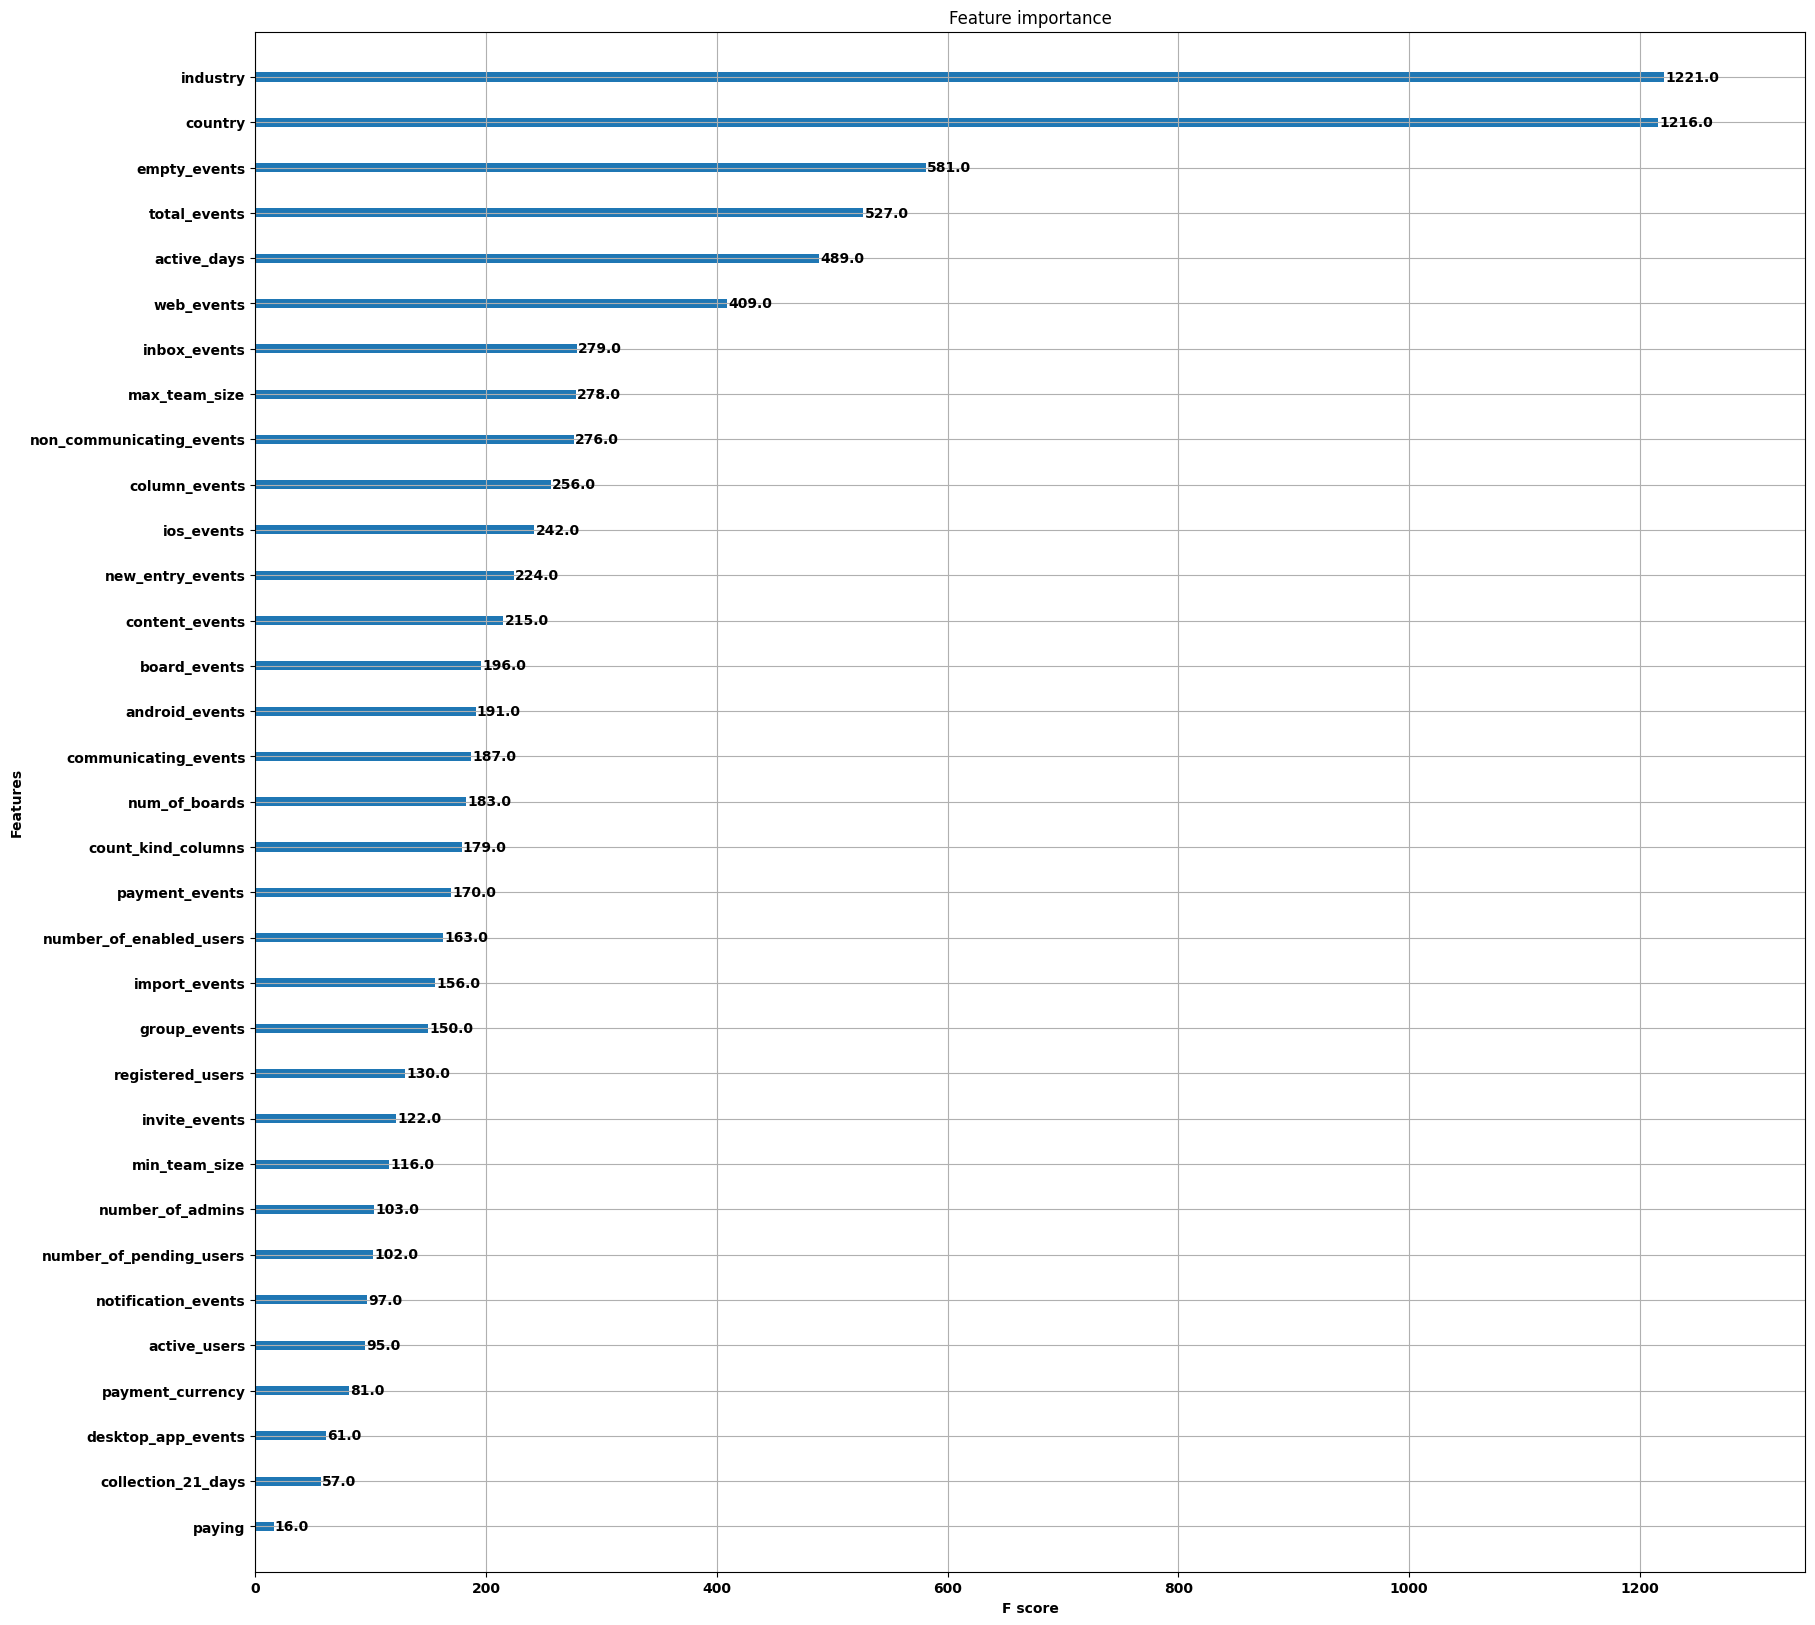

In [81]:
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (20, 20)
# font = {"size": 10}

plt.rc("font", **{})


plot_importance(model)

plt.show()